# Initialization

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

tfk = tf.keras
tfkl = tfk.layers

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [10]:
%cd /content/drive/MyDrive/SecondCompetition/

/content/drive/MyDrive/SecondCompetition


In [18]:
!mkdir /dataset
!cp ./Training.csv /dataset/

In [19]:
DATASET_FILE = '/dataset/Training.csv'
CONST_THRESHOLD = 0.2

# Dataset Visualization

In [20]:
dataset = pd.read_csv(DATASET_FILE).astype('float32')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 1.8 MB


In [21]:
dataset.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.976980,4.33494,10.672820,1.76692,3.22440,51.681461,3.65434
1,8.078239,4.44616,10.561601,1.70716,3.32566,51.563599,3.47672
2,8.028440,4.22372,10.561601,1.64906,3.17460,50.863079,3.47672
3,8.028440,4.22372,10.561601,1.70716,3.17460,45.841579,3.47672
4,7.875721,4.44616,10.450379,1.70716,3.27586,47.126423,3.47672


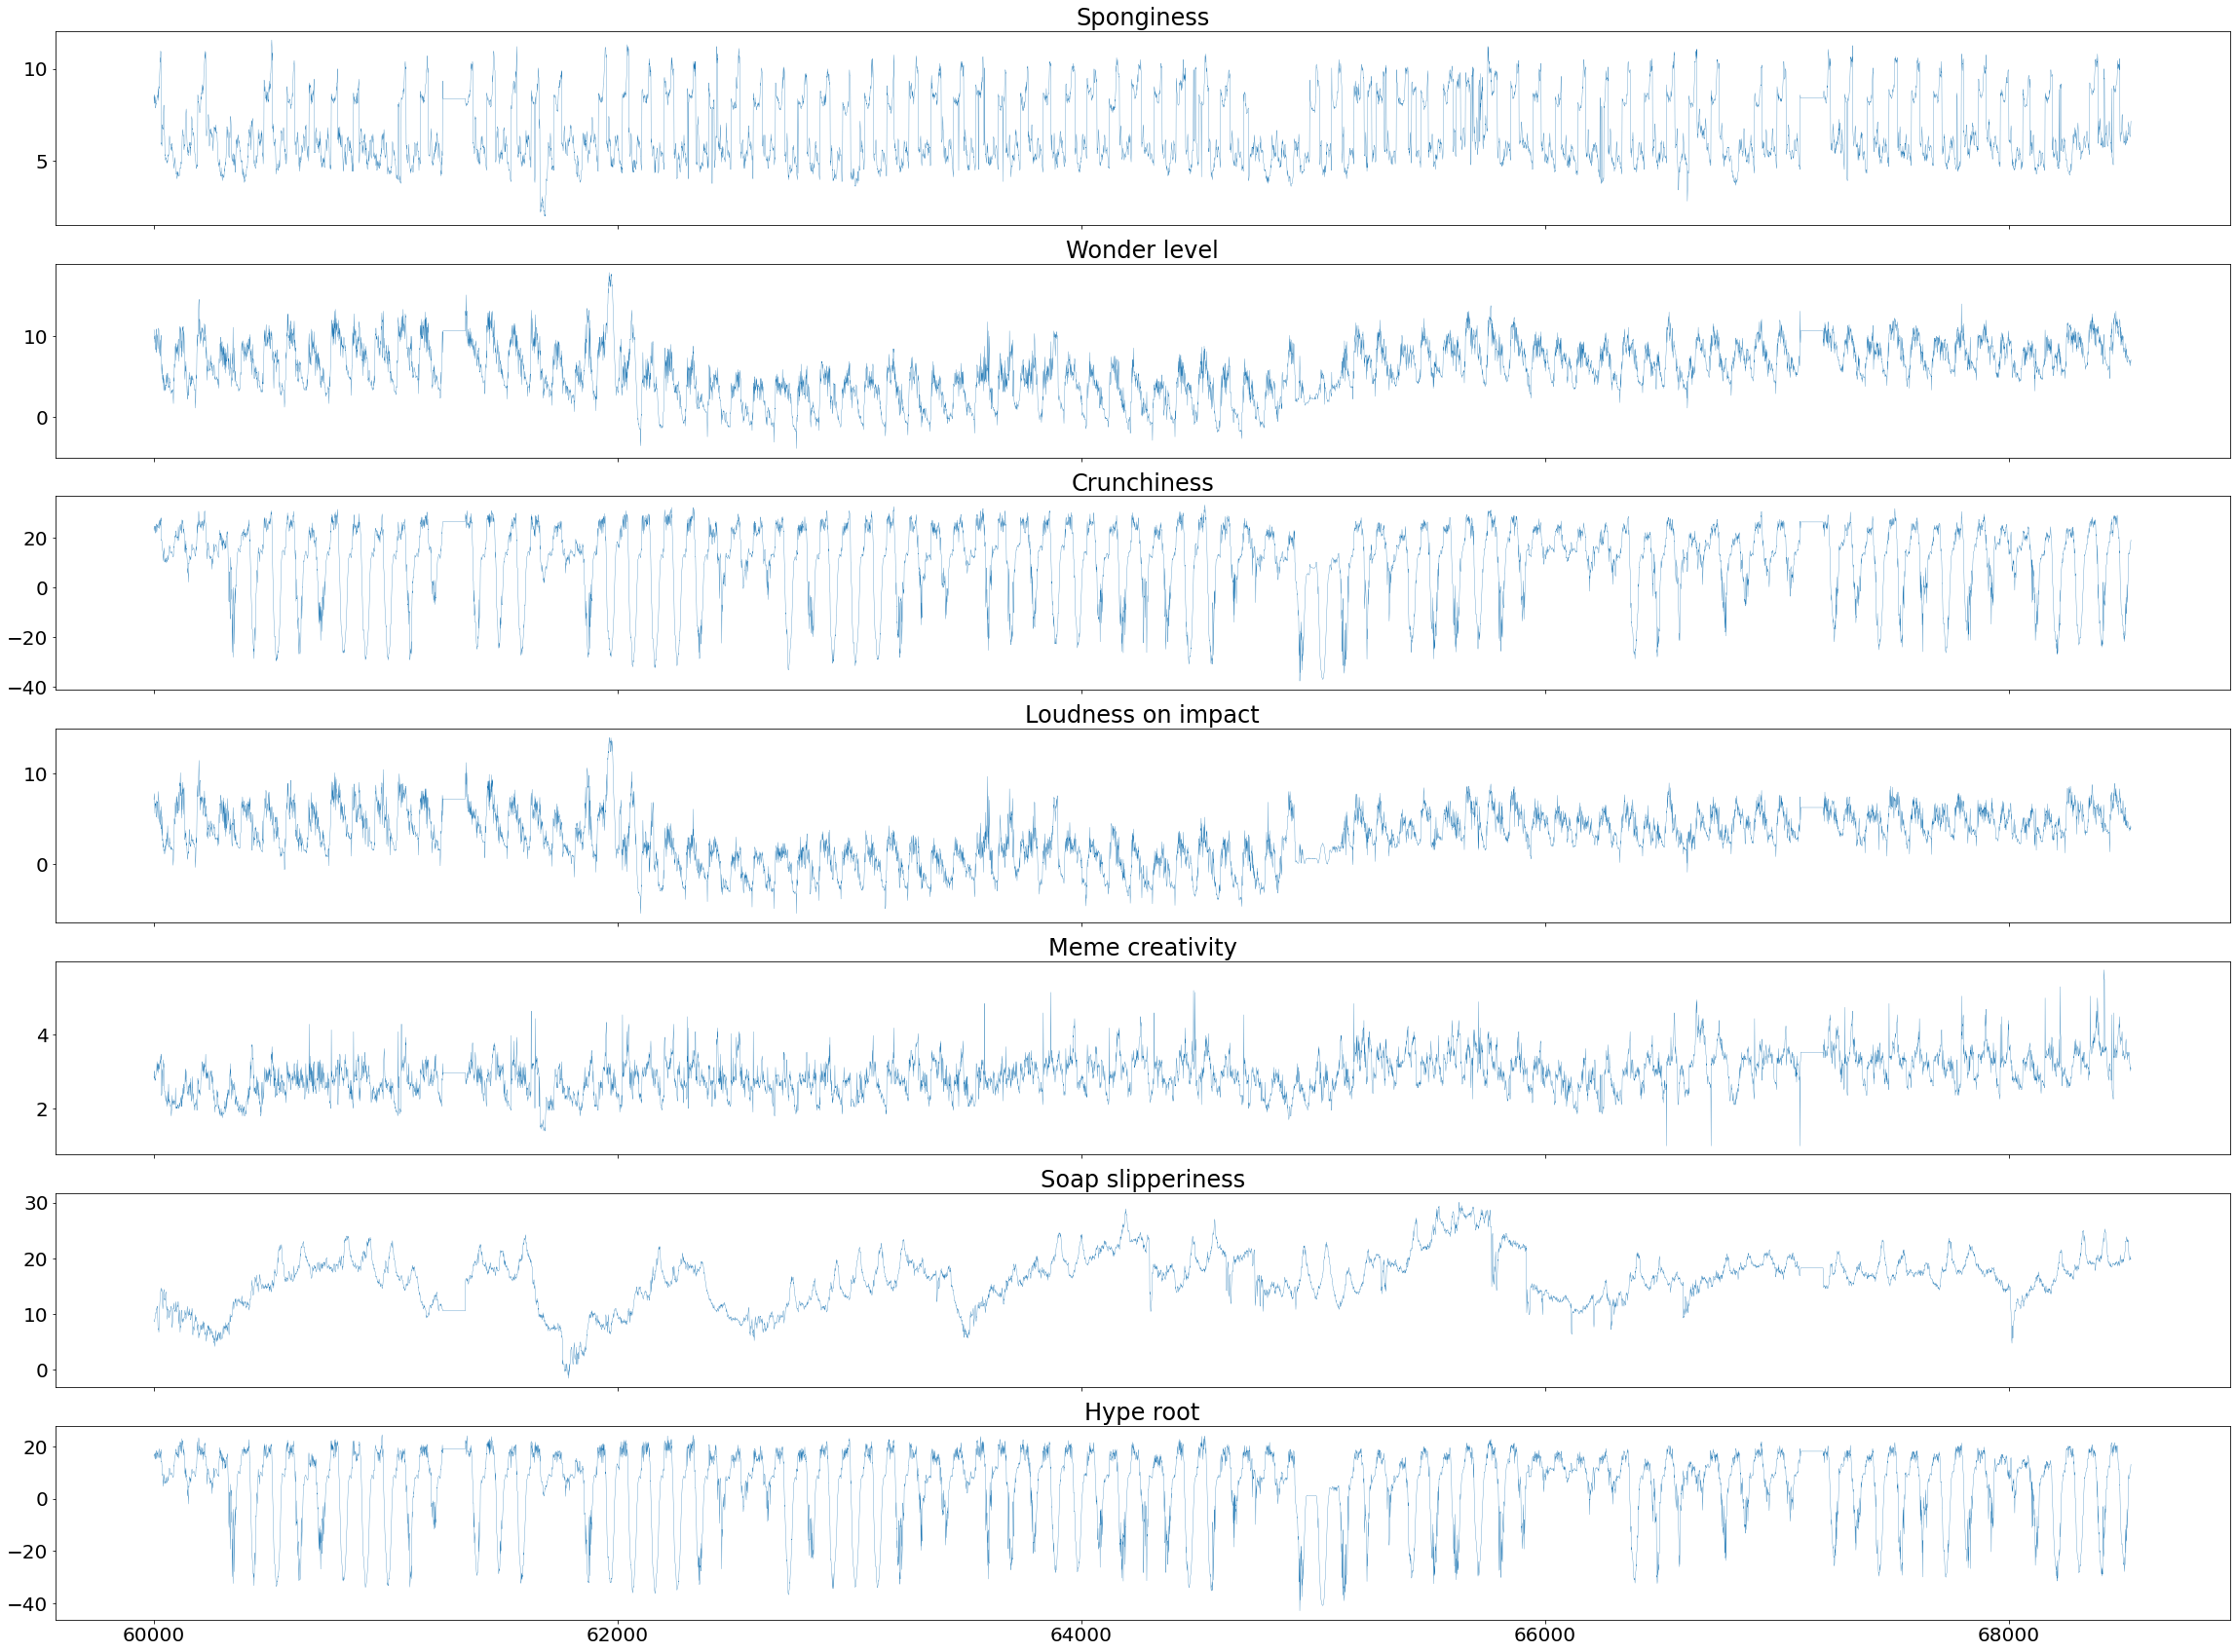

In [22]:
def inspect_dataframe(df, columns, line_width=0.3):
    #plt_range = (37000,38000) #Sponginess flatline
    #plt_range = (15000,15500)
    #plt_range = (0,10000)
    plt_range = (60000,len(df))
    plt.rcParams.update({'font.size': 20})
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(40,30))
    for i, col in enumerate(columns):
        axs[i].plot(df[col][plt_range[0]:plt_range[1]], linewidth=line_width)
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

# Dataset Analysis

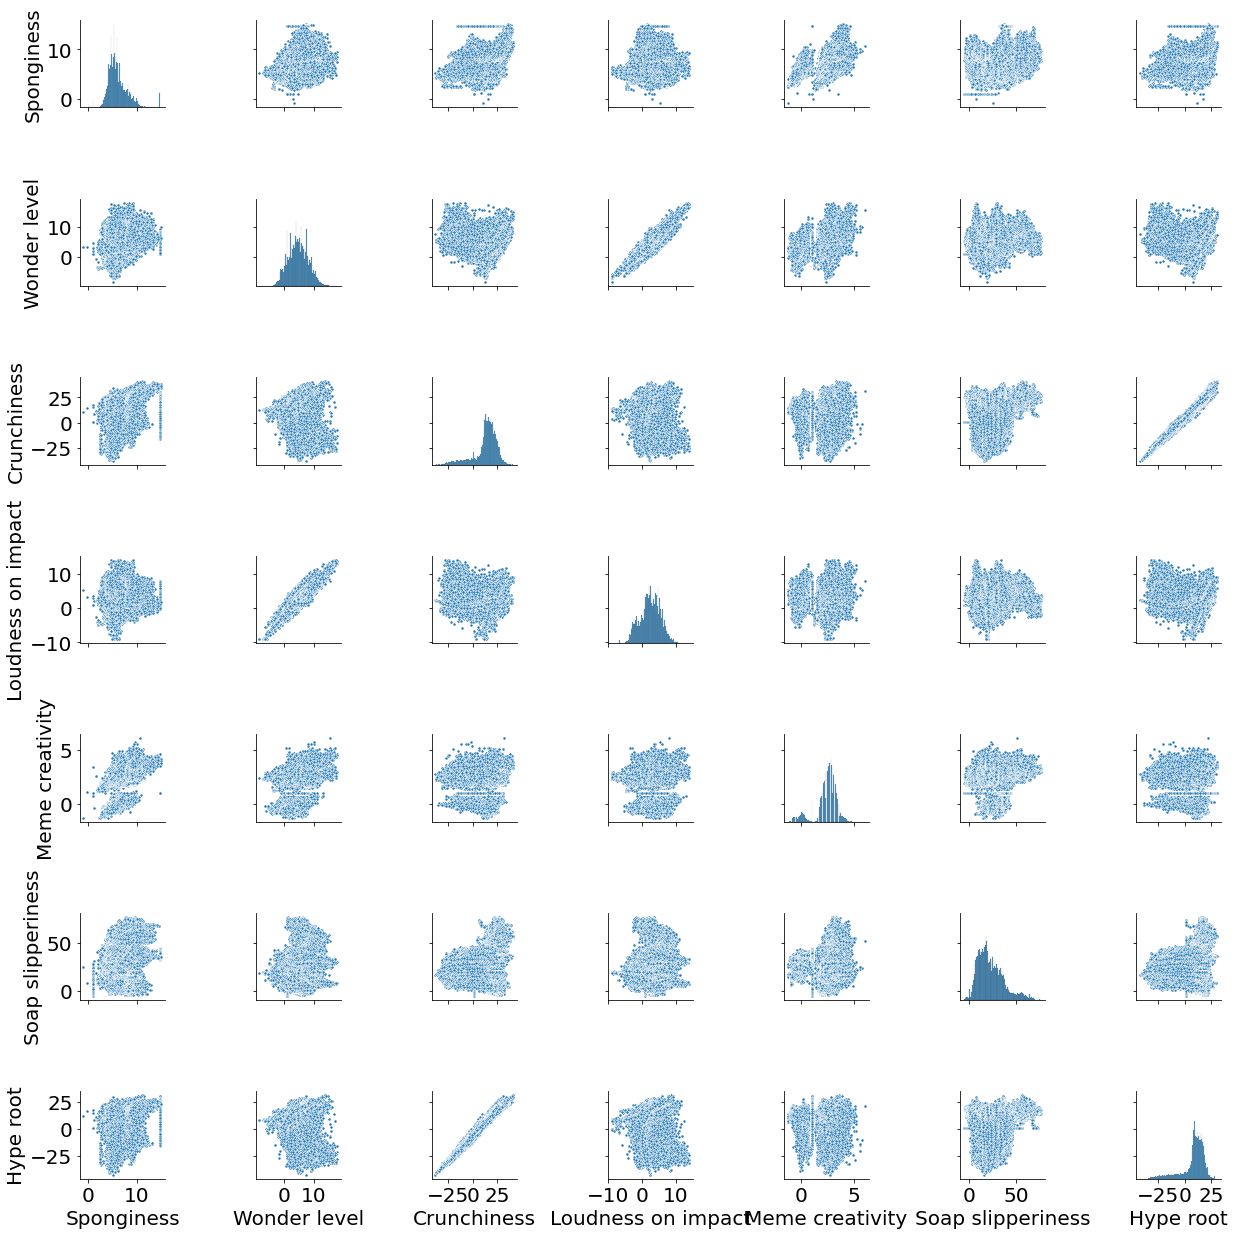

In [23]:
sns.pairplot(data=dataset, markers='.')

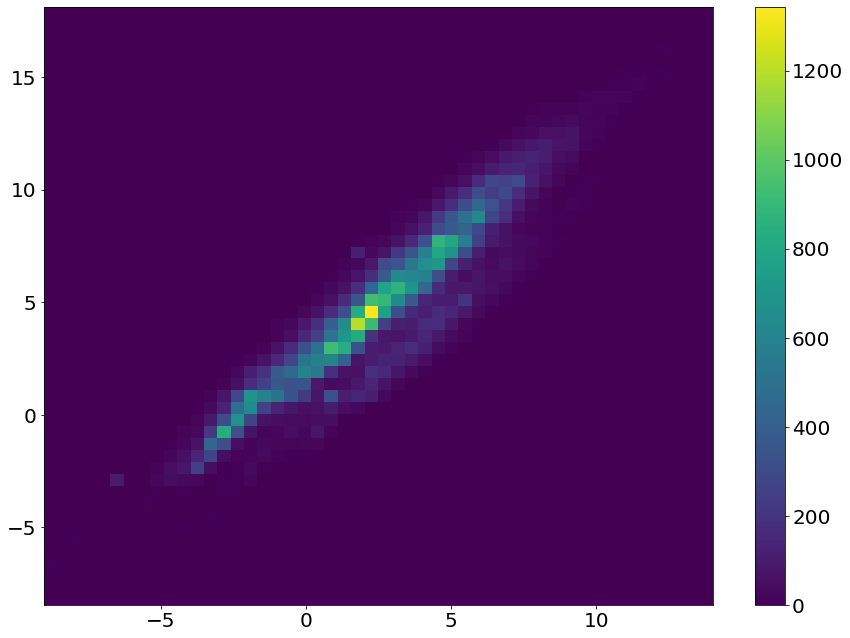

In [24]:
# Visualize correlation between signals
plt.subplots(figsize=(15,11))
plt.hist2d(dataset['Loudness on impact'], dataset['Wonder level'], bins=(50,50))
plt.colorbar()

In [26]:
# Find constant intervals
def find_constants(ds=dataset, min_len=10):
    
    const_df = pd.DataFrame(data=None, columns=ds.columns, index=ds.index)
    ranges = {}

    for col in ds.columns:
        ranges[col] = []
        count = 0
        t = ds[col][0]
        for i, el in enumerate(ds[col]):
            if t == el:
                count += 1
            else:
                if count >= min_len:
                    ranges[col].append((i-count,i))
                    const_df[col][i-count:i] = t
                t = el
                count = 0
    
    # assert correctness
    for col in ds.columns:
        for ran in ranges[col]:
            for x,y in zip(ds[col][ran[0]:ran[1]], const_df[col][ran[0]:ran[1]]):
                assert(x == y)
                
    return const_df, ranges

const_df, const_ranges = find_constants()

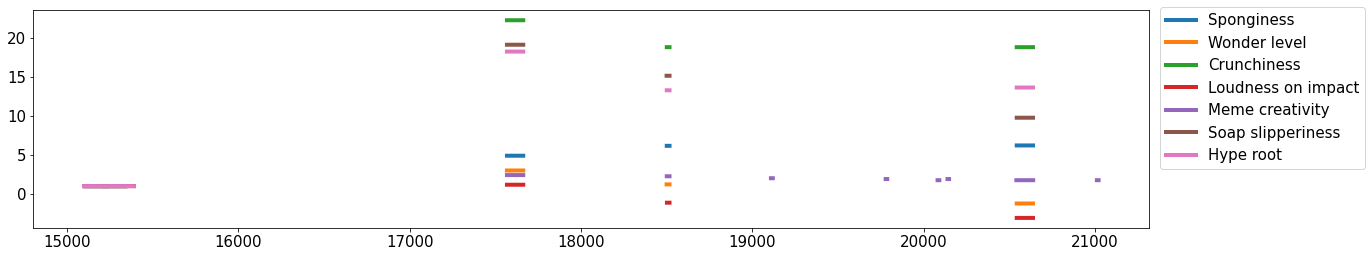

In [34]:
# Plot constant intervals
plt_range = (15000,25000)
plt.rcParams.update({'font.size': 15})
figs, ax = plt.subplots(figsize=(20,4))
for col in const_df.columns:
    ax.plot(const_df[col][plt_range[0]:plt_range[1]], linewidth=4, label=col)
ax.legend(bbox_to_anchor=(1.20, 1.05))
plt.show()

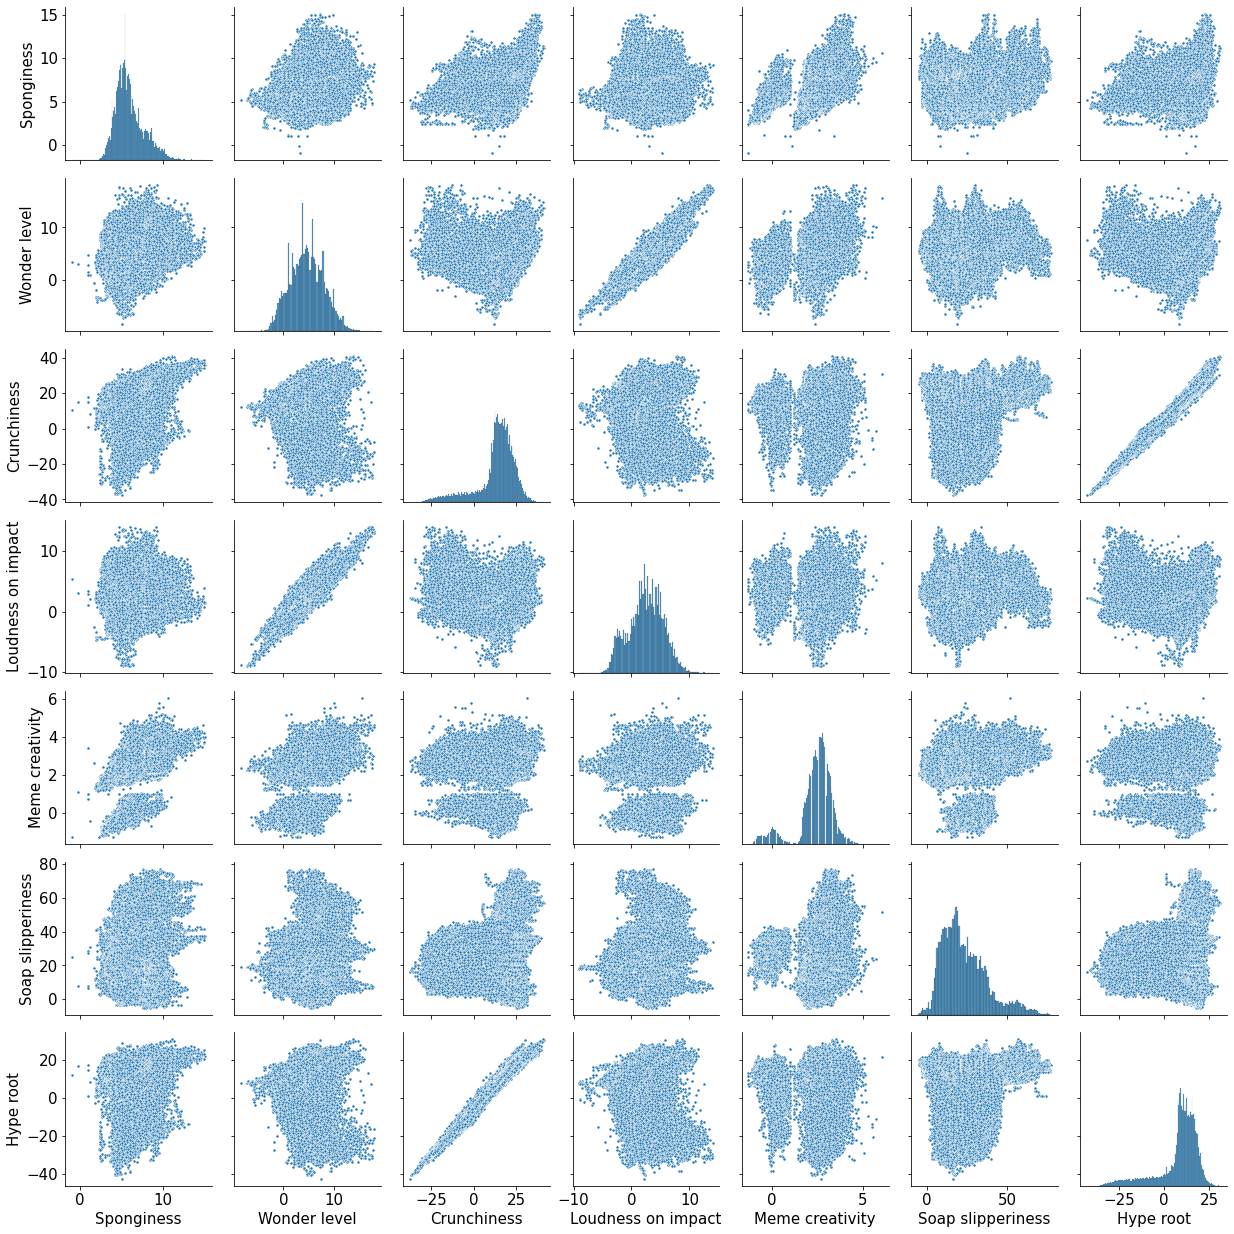

In [35]:
# pairplot without corrupted values
temp = pd.read_csv(DATASET_FILE).astype('float32')

for col in temp.columns:
    for ran in const_ranges[col]:
        temp[col][ran[0]:ran[1]] = None
        
sns.pairplot(data=temp, markers='.')
temp = None

In [36]:
# Use Dickey-Fuller test to infer if data is stationary
from statsmodels.tsa.stattools import adfuller

for col in dataset.columns:
    adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(dataset[col])
    msg = col + ' IS stationary, pvalue:' if pvalue < 0.05 else col + ' IS NOT stationary, probability value:'
    print(msg, pvalue)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Sponginess IS stationary, pvalue: 4.4272267803744156e-29
Wonder level IS stationary, pvalue: 8.583264463560346e-22
Crunchiness IS stationary, pvalue: 0.0
Loudness on impact IS stationary, pvalue: 1.0156150566810698e-20
Meme creativity IS stationary, pvalue: 5.713964884206699e-10
Soap slipperiness IS stationary, pvalue: 0.000778163451179482
Hype root IS stationary, pvalue: 0.0


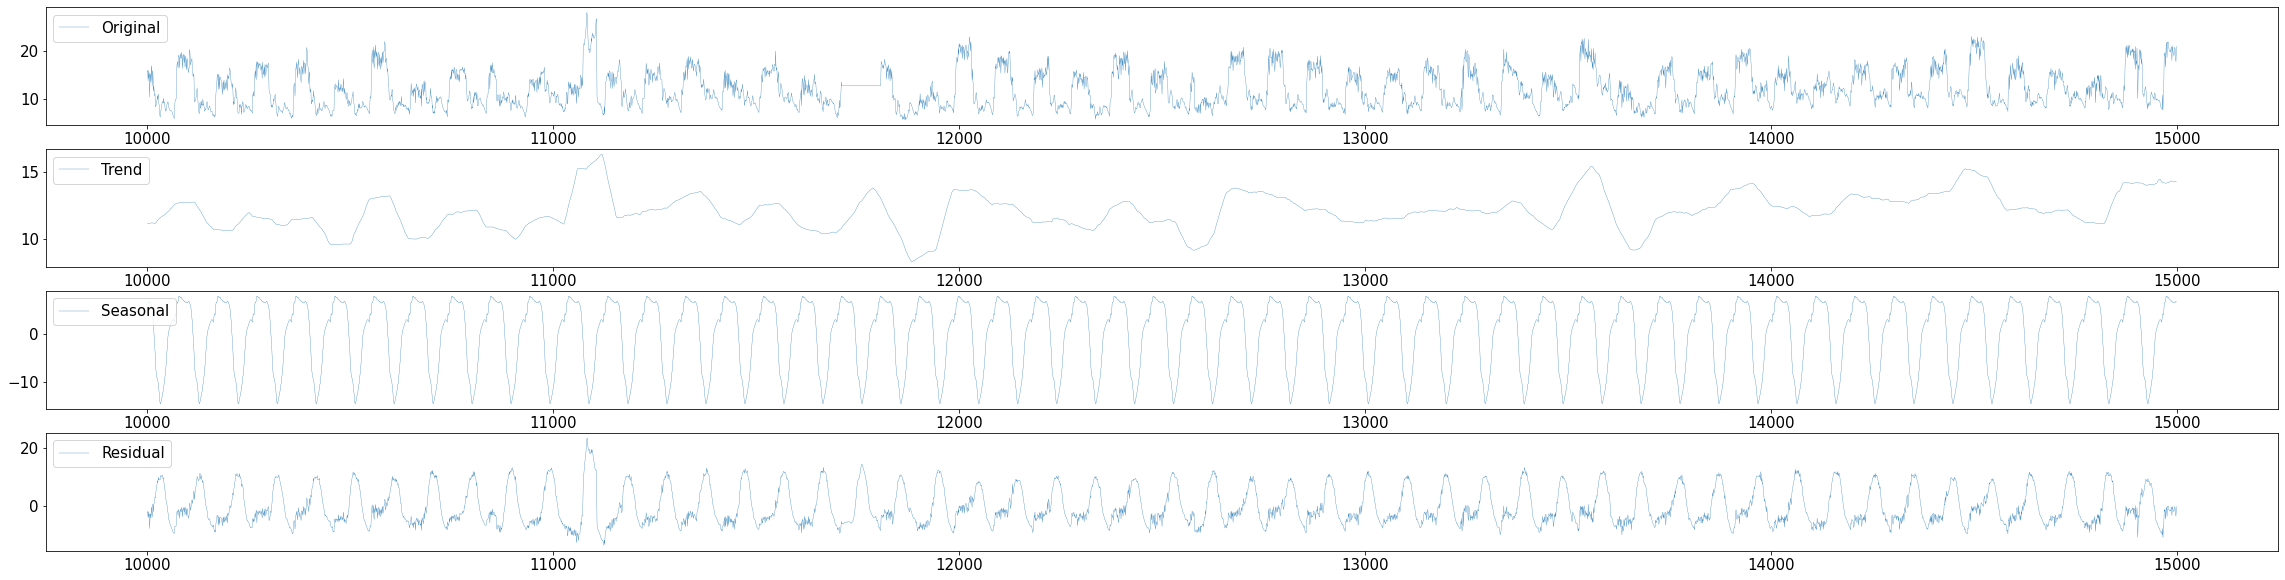

In [39]:
# Check if data has a trend and/or is seasonal
from statsmodels.tsa.seasonal import seasonal_decompose

col = 'Hype root'
period = 96
plt_range = (10000,15000)

decomposed = seasonal_decompose(dataset[col], model='additive', freq=period)

trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

plt.figure(figsize=(40,10))
plt.subplot(411)
plt.plot(dataset[col][plt_range[0]:plt_range[1]], label='Original', linewidth=0.3)
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend[plt_range[0]:plt_range[1]], label='Trend', linewidth=0.3)
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal[plt_range[0]:plt_range[1]], label='Seasonal', linewidth=0.3)
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual[plt_range[0]:plt_range[1]], label='Residual', linewidth=0.3)
plt.legend(loc='upper left')
plt.show()

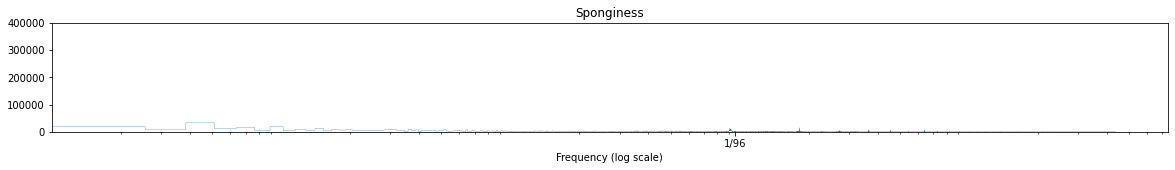

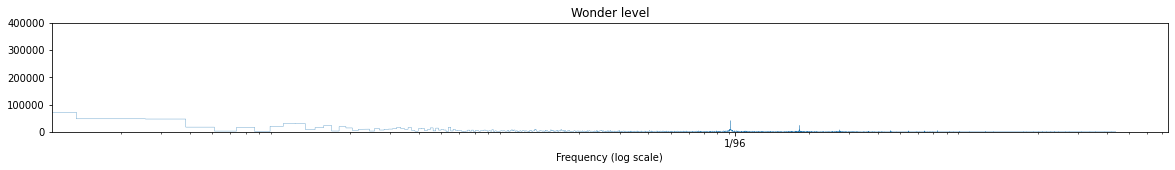

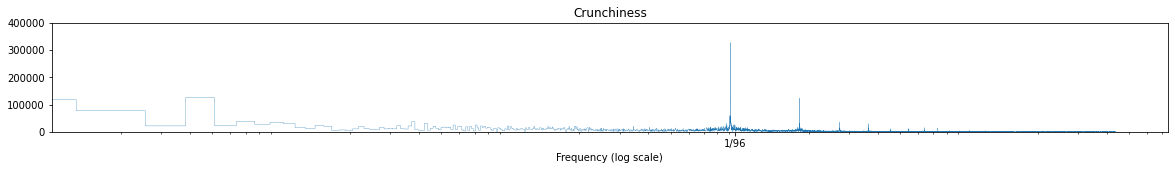

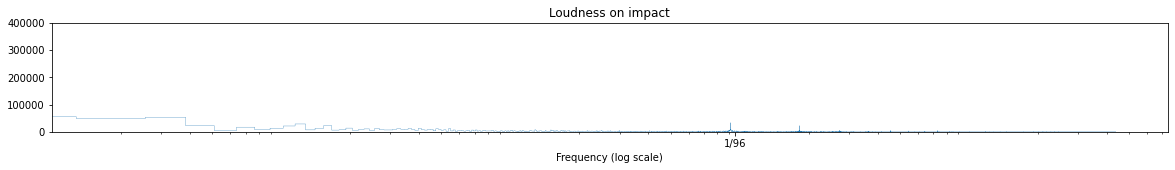

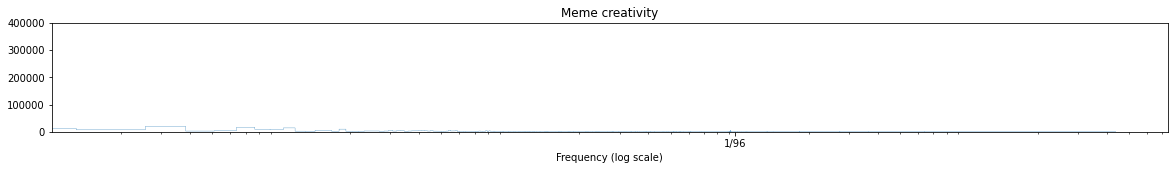

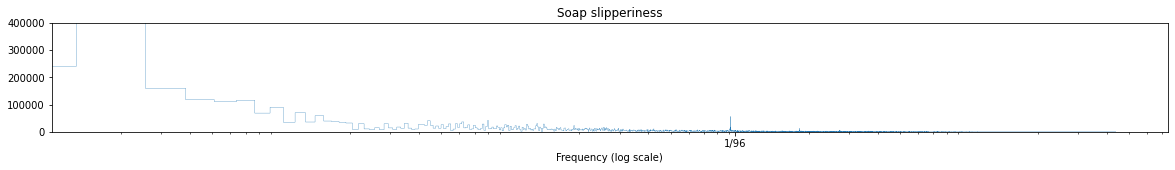

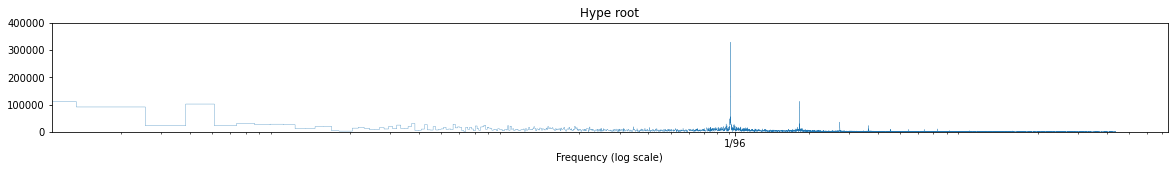

In [40]:
# use fast fourier transform to identify relevant frequencies

for col in dataset.columns:
    fft = tf.signal.rfft(dataset[col])
    f_per_dataset = np.arange(0,len(fft))

    n_samples_h = len(dataset[col])
    hours_per_year = 24*365.2524
    years_per_dataset = n_samples_h/(hours_per_year)

    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=(20,2))

    f_per_year = f_per_dataset/years_per_dataset
    plt.title(col)
    plt.step(f_per_year, np.abs(fft), linewidth=0.3)
    plt.xscale('log')
    plt.ylim(0, 400000)
    plt.xlim([0.1, max(plt.xlim())])
    plt.xticks([96], labels=['1/96'])
    _ = plt.xlabel('Frequency (log scale)')

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


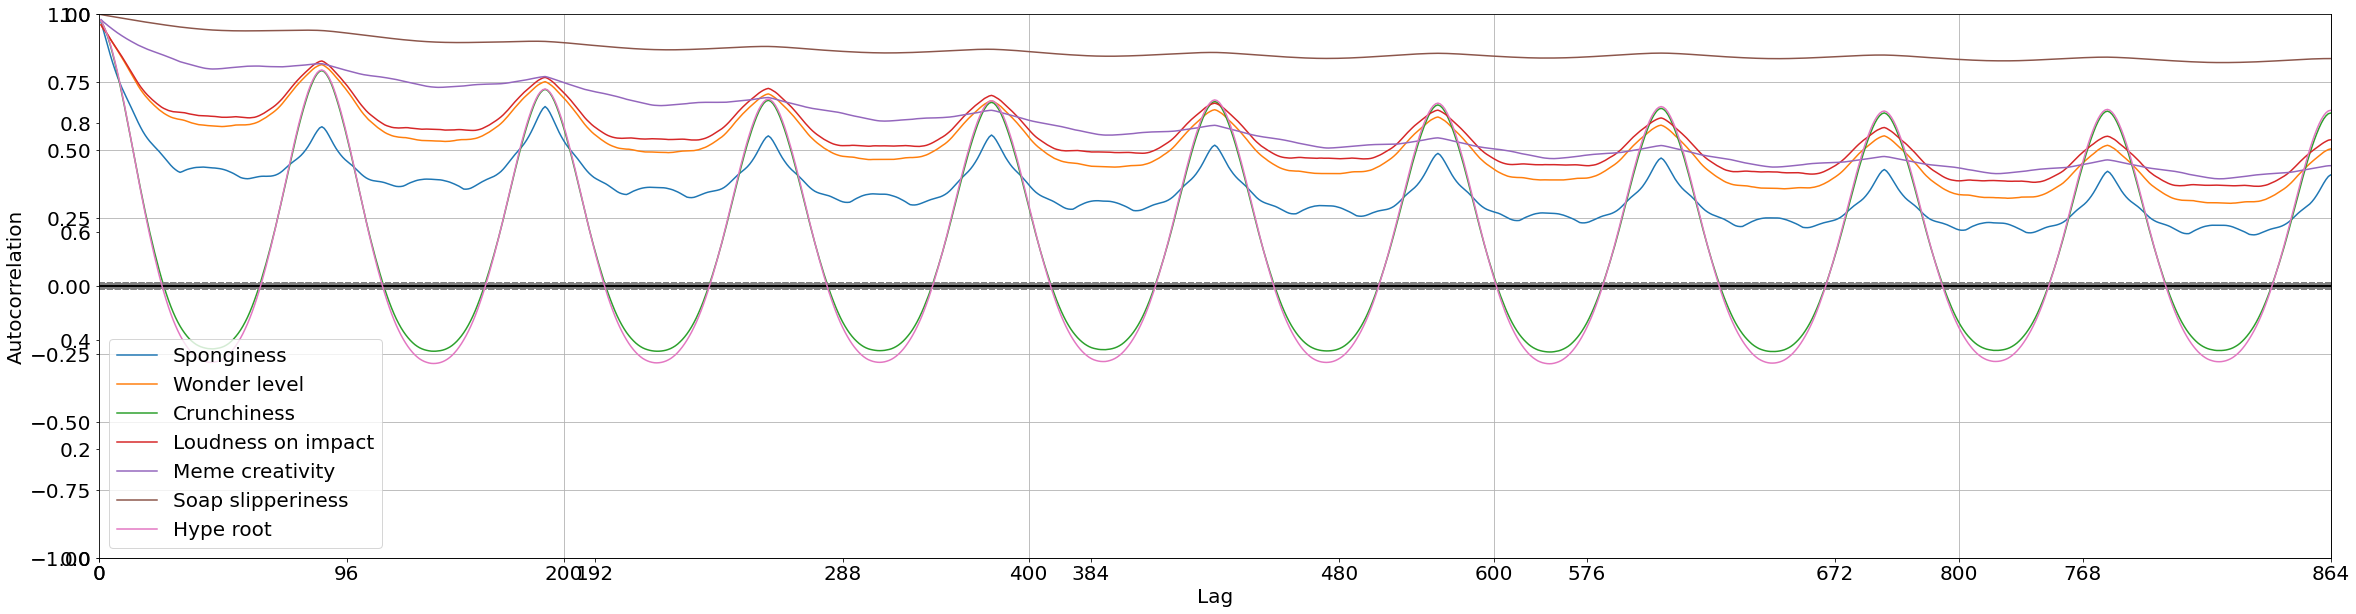

In [41]:
# Explore correlation values
from pandas.plotting import autocorrelation_plot

freq = 96
x1 = 0
x2 = 1000
plt_range = (x1 - (x1 % 96),x2 - (x2 % 96))
cols = dataset.columns
# cols = ['Sponginess']

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(40,10))
plt.xticks(range(plt_range[0],plt_range[1],freq))
for col in cols:
    autocorrelation_plot(dataset[col], label=col).set_xlim([plt_range[0], plt_range[1]])